## Example study - 2
This jupyter notebook creates plots to study the impact of disabling charging stations


### 0. Analysis IDs to compare

In [1]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (22, )

### 1. Package Installs

In [2]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [3]:
# Seaborn for plotting
#!pip install seaborn

In [4]:
# Plotly for plotting 
#!pip install plotly

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px

### 2. Environment Variables

In [6]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [7]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'chargeval_dev'

### 3. Database connection

In [8]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [9]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 12.3 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [10]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [11]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(42995,)

In [12]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

,count,analysis_id
0,1204,314
1,1203,315
2,1203,317
3,1203,313
4,1183,316


In [13]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

,count,analysis_id
0,1195,314
1,1195,315
2,1195,317
3,1195,313
4,1173,316


In [14]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

,count,analysis_id
0,9,314
1,8,317
2,8,313
3,10,316
4,8,315


In [15]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, coalesce(ne.count, 0) as nevse_count
from ev_stranded est
         left join (
    select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on est.analysis_id = ne.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY nevse_count;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

,stranded_lat,stranded_lng,analysis_id,nevse_count
0,46.840208,-117.338909,314,0
1,47.679314,-122.539140,314,0
2,47.658407,-122.523516,314,0
3,47.300756,-122.572303,314,0
4,47.268449,-122.550454,314,0


In [16]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

,sum,analysis_id
0,134555.0,314
1,134590.0,315
2,134574.0,317
3,134609.0,313
4,129852.0,316


In [17]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

,count,analysis_id
0,813,314
1,788,315
2,796,317
3,804,313
4,778,316


In [18]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

,count,analysis_id
0,448,314
1,463,315
2,449,317
3,416,313
4,427,316


In [42]:
basecase_aid = 307
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       coalesce(ne.count, 0)               as nevse_count
FROM evse_power_draw epd
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on epd.analysis_id = ne.analysis_id
WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN %s UNION (select %s as analysis_id))
GROUP BY epd.simulation_ts, epd.analysis_id, nevse_count
ORDER BY nevse_count, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id,basecase_aid))
evse_util

,analysis_id,datetime,total_power,nevse_count
0,307,2019-07-01 08:00:46,0,0
1,313,2019-07-01 08:00:46,0,0
2,314,2019-07-01 08:00:46,0,0
3,315,2019-07-01 08:00:46,0,0
4,316,2019-07-01 08:00:46,0,0
...,...,...,...,...
5602,314,2019-07-02 01:45:46,0,0
5603,314,2019-07-02 01:46:46,0,0
5604,314,2019-07-02 01:47:46,0,0
5605,314,2019-07-02 01:48:46,0,0


In [70]:
sql_aids = """select analysis_id from analysis_record where set_id IN %s order by analysis_id"""
a_ids = pd.read_sql_query(sql=sql_aids, con=conn, params=(set_id,))['analysis_id'].tolist()
a_ids = a_ids[:-1]
a_ids

[313, 314, 315, 316, 317]

In [72]:
bevse_df = pd.DataFrame(columns=['latitude', 'longitude', 'bevse_id', 'analysis_id'])
for a_id in a_ids: 
    sql_disabled_bevses = """select be.latitude, be.longitude, be.bevse_id
from built_evse be where dcfc_count > 0 and connector_code IN (1, 2, 3)
    except all
select en.latitude, en.longitude, cast(SUBSTRING(en.evse_id from 2) as double precision) as bevse_id
from evses_now en
where analysis_id = %s"""
    disabled_bevses = pd.read_sql_query(sql=sql_disabled_bevses, con=conn, params=(a_id,))
    disabled_bevses['analysis_id'] = a_id
    # print(disabled_bevses)
    bevse_df = bevse_df.append(disabled_bevses)
    # print(bevse_df)

    latitude   longitude  bevse_id  analysis_id
0  47.547708 -122.352708   96763.0          313
1  47.128521 -119.281586  156236.0          313
2  45.619627 -122.644780  155995.0          313
3  47.242930 -122.396770  143215.0          313
4  46.679250 -122.975256  143835.0          313
5  47.820568 -122.273567   93552.0          313
6  46.677105 -120.478546  103581.0          313
7  48.755607 -122.454132   39778.0          313
8  47.470772 -122.220207   99059.0          313
9  47.652505 -122.694367   95368.0          313
    latitude   longitude  bevse_id analysis_id
0  47.547708 -122.352708   96763.0         313
1  47.128521 -119.281586  156236.0         313
2  45.619627 -122.644780  155995.0         313
3  47.242930 -122.396770  143215.0         313
4  46.679250 -122.975256  143835.0         313
5  47.820568 -122.273567   93552.0         313
6  46.677105 -120.478546  103581.0         313
7  48.755607 -122.454132   39778.0         313
8  47.470772 -122.220207   99059.0         313
9 

In [73]:
len(bevse_df)

50

In [47]:
basecase_aid = 307
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       coalesce(ne.count, 0) as nevse_count,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on ets.analysis_id = ne.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s UNION (select %s as analysis_id))
group by ets.analysis_id, nevse_count, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,basecase_aid))
count_stats.sort_values(by=['analysis_id'], inplace=True)
count_stats

,sim_count,analysis_id,nevse_count,fin_count,evmt,str_count,cs_count,wait_count
3,1204,307,0,1193,134209.0,11,815,455
0,1203,313,0,1195,134609.0,8,804,416
2,1204,314,0,1195,134555.0,9,813,448
5,1203,315,0,1195,134590.0,8,788,463
4,1183,316,0,1173,129852.0,10,778,427
1,1203,317,0,1195,134574.0,8,796,449


In [48]:
# count_stats.dtypes
# count_stats = count_stats.sort_values(by=['nevse_count'])
# count_stats

In [49]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       coalesce(ne.count, 0) as nevse_count,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on (lai.row_data -> 'analysis_id')::int = ne.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
ORDER BY nevse_count
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,nevse_count,time_taken_tripgen,time_taken_eviabm
0,2020-12-14 21:02:03.069833+00:00,313,2020-12-14 21:18:13.347500+00:00,2020-12-15 00:12:45.697318+00:00,# EV: 1203,0,16.0,174.0
1,2020-12-14 21:02:14.984044+00:00,317,2020-12-14 21:18:23.958671+00:00,2020-12-15 00:12:48.858865+00:00,# EV: 1203,0,16.0,174.0
2,2020-12-14 21:02:14.412901+00:00,315,2020-12-14 21:18:27.402161+00:00,2020-12-15 00:20:41.194385+00:00,# EV: 1203,0,16.0,182.0
3,2020-12-14 21:02:14.698447+00:00,316,2020-12-14 21:18:31.072253+00:00,2020-12-15 00:05:58.700367+00:00,# EV: 1183,0,16.0,167.0
4,2020-12-14 21:02:14.123747+00:00,314,2020-12-14 21:18:35.971327+00:00,2020-12-15 00:10:35.211396+00:00,# EV: 1204,0,16.0,171.0


### 5. Plotting

#### 5.1 Vehicle Counts

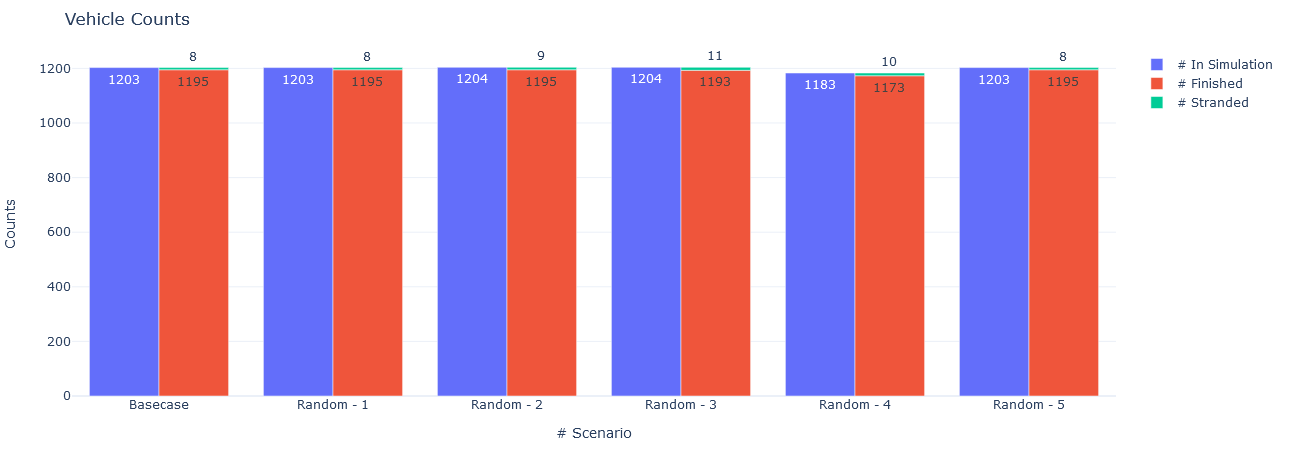

In [46]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# In Simulation",
            x=count_stats['analysis_id'],
            y=count_stats['sim_count'],
            offsetgroup=0,
            text=count_stats['sim_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Finished",
            x=count_stats['analysis_id'],
            y=count_stats['fin_count'],
            offsetgroup=1,
            text=count_stats['fin_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Stranded",
            x=count_stats['analysis_id'],
            y=count_stats['str_count'],
            offsetgroup=1,
            base=count_stats['fin_count'],
            text=count_stats['str_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Vehicle Counts",
        yaxis_title="Counts", 
        xaxis_title="# Scenario", width=600, height=450
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2, 3, 4, 5], ticktext=['Basecase', 'Random - 1', 'Random - 2', 'Random - 3', 'Random - 4', 'Random - 5'])
# fig.update_yaxes(range=(0, 1300))
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

## 5.2 eVMT

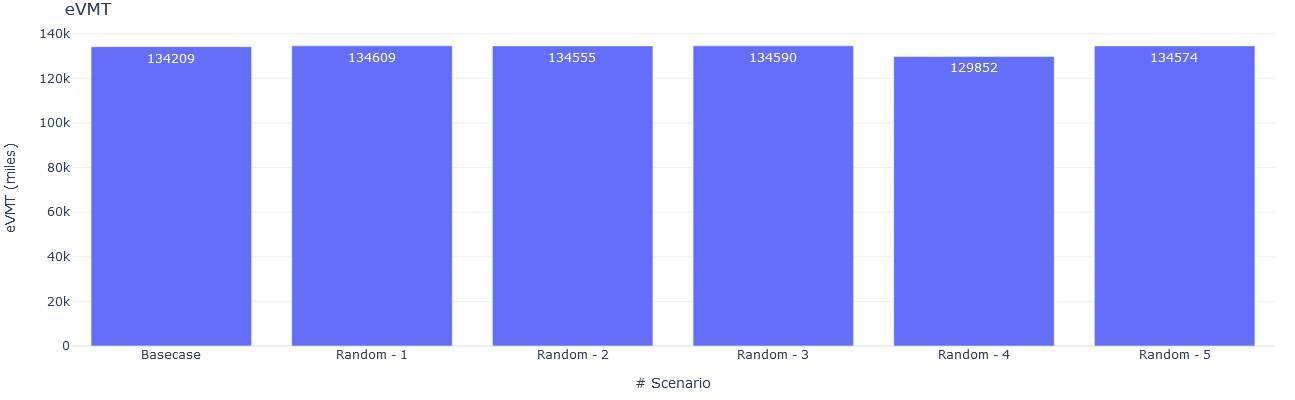

In [50]:
fig = go.Figure(
    data=[
        go.Bar(
            name="eVMT",
            x=count_stats['analysis_id'],
            y=count_stats['evmt'],
            offsetgroup=1,
            text=count_stats['evmt'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="eVMT",
        yaxis_title="eVMT (miles)", 
        xaxis_title="# Scenario", uniformtext_minsize=8, uniformtext_mode='hide', width=400, height=400
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2, 3, 4, 5], ticktext=['Basecase', 'Random - 1', 'Random - 2', 'Random - 3', 'Random - 4', 'Random - 5'])
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.3 Charging and Waiting Sessions

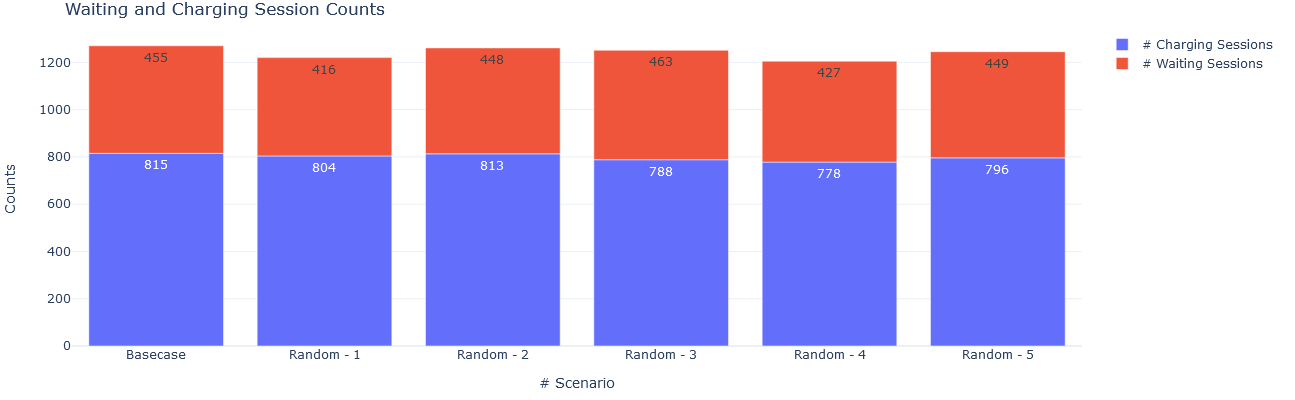

In [51]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# Charging Sessions",
            x=count_stats['analysis_id'],
            y=count_stats['cs_count'],
            offsetgroup=1,
            text=count_stats['cs_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Waiting Sessions",
            x=count_stats['analysis_id'],
            y=count_stats['wait_count'],
            offsetgroup=1,
            base=count_stats['cs_count'],
            text=count_stats['wait_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Waiting and Charging Session Counts",
        yaxis_title="Counts", 
        xaxis_title="# Scenario", width=600, height=400
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2, 3, 4, 5], ticktext=['Basecase', 'Random - 1', 'Random - 2', 'Random - 3', 'Random - 4', 'Random - 5'])
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.4 EVSE Utilization

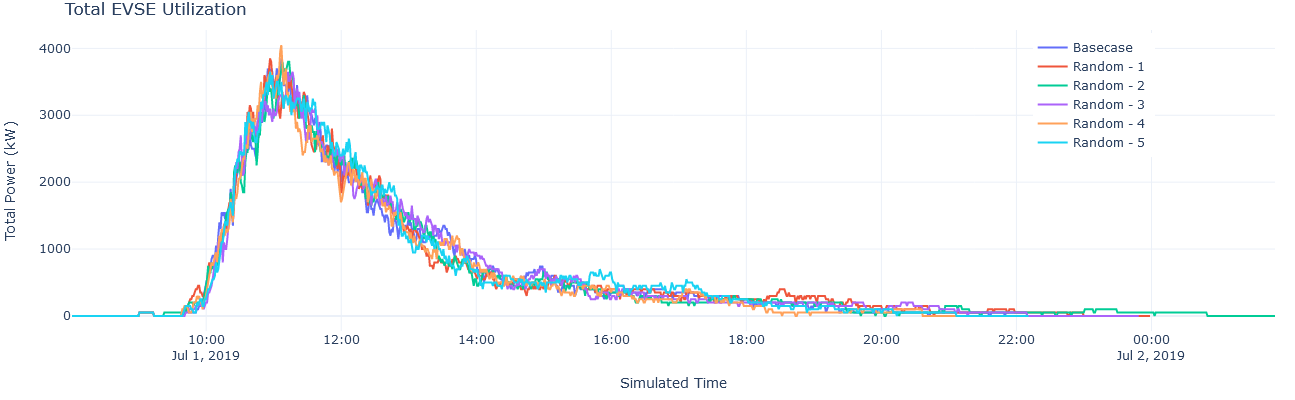

In [53]:
#fig = px.line(evse_util, x="datetime", y="total_power", color='analysis_id', name=['Basecase', 'Scenario - 1', 'Scenario - 2', 'Scenario - 3'], range_x=['2019-07-01 06:00','2019-07-02'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 307]['datetime'], y=evse_util[evse_util['analysis_id'] == 307]['total_power'],
                    mode='lines',
                    name='Basecase'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 313]['datetime'], y=evse_util[evse_util['analysis_id'] == 313]['total_power'],
                    mode='lines',
                    name='Random - 1'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 314]['datetime'], y=evse_util[evse_util['analysis_id'] == 314]['total_power'],
                    mode='lines',
                    name='Random - 2'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 315]['datetime'], y=evse_util[evse_util['analysis_id'] == 315]['total_power'],
                    mode='lines',
                    name='Random - 3'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 316]['datetime'], y=evse_util[evse_util['analysis_id'] == 316]['total_power'],
                    mode='lines',
                    name='Random - 4'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 317]['datetime'], y=evse_util[evse_util['analysis_id'] == 317]['total_power'],
                    mode='lines',
                    name='Random - 5'))

fig.update_layout(title="Total EVSE Utilization",
                  yaxis_title="Total Power (kW)", 
                  xaxis_title="Simulated Time", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=1000, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20), template='plotly_white', showlegend=True, legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.9
))
fig.show()

In [76]:
token = os.getenv("MAPBOX_ACCESS_TOKEN")
# analysis_ids = new_evses['analysis_id'].unique()

In [83]:
len(bevse_df['analysis_id'].unique())

5

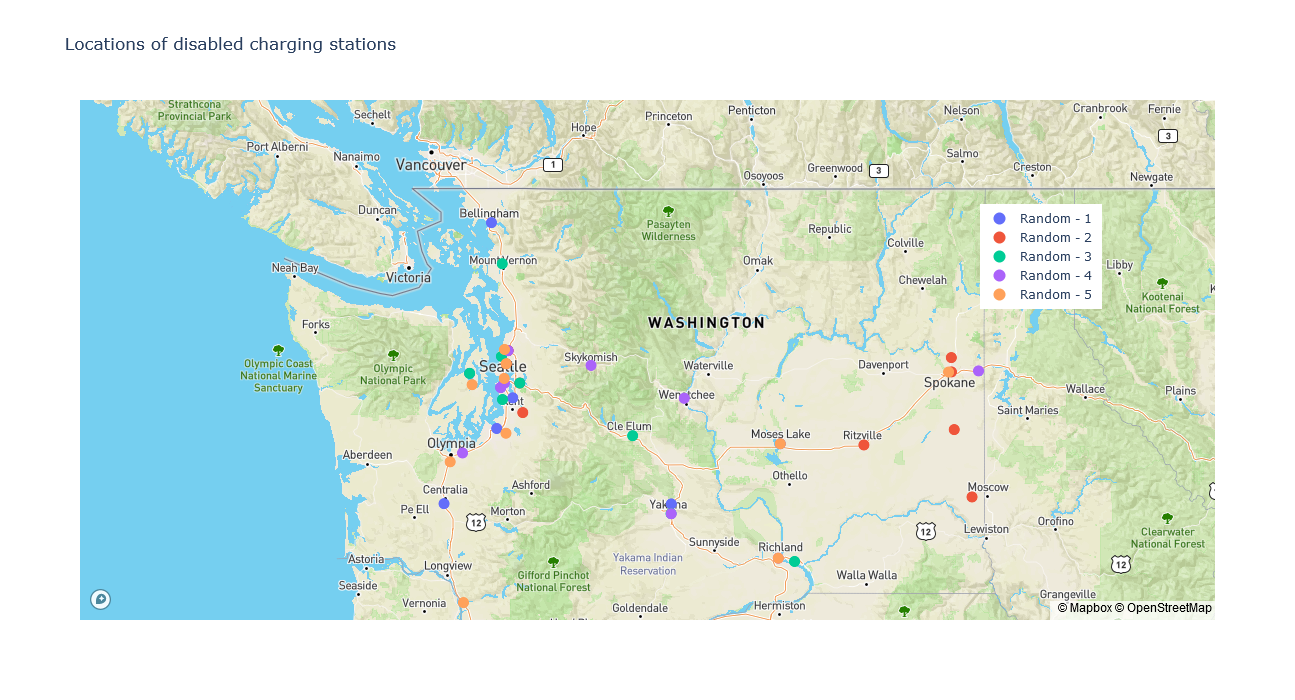

In [100]:
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
        lat=bevse_df[bevse_df['analysis_id'] == a_ids[0]]['latitude'],
        lon=bevse_df[bevse_df['analysis_id'] == a_ids[0]]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color=a_ids[0],
            opacity=1
        ),
        hoverinfo='none', 
    name='Random - 1'
    ))
fig.add_trace(go.Scattermapbox(
        lat=bevse_df[bevse_df['analysis_id'] == a_ids[1]]['latitude'],
        lon=bevse_df[bevse_df['analysis_id'] == a_ids[1]]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color=a_ids[1],
            opacity=1
        ),
        hoverinfo='none', 
    name='Random - 2'
    ))
fig.add_trace(go.Scattermapbox(
        lat=bevse_df[bevse_df['analysis_id'] == a_ids[2]]['latitude'],
        lon=bevse_df[bevse_df['analysis_id'] == a_ids[2]]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color=a_ids[2],
            opacity=1
        ),
        hoverinfo='none', 
    name='Random - 3'
    ))
fig.add_trace(go.Scattermapbox(
        lat=bevse_df[bevse_df['analysis_id'] == a_ids[3]]['latitude'],
        lon=bevse_df[bevse_df['analysis_id'] == a_ids[3]]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color=a_ids[3],
            opacity=1
        ),
        hoverinfo='none', 
    name='Random - 4'
    ))
fig.add_trace(go.Scattermapbox(
        lat=bevse_df[bevse_df['analysis_id'] == a_ids[4]]['latitude'],
        lon=bevse_df[bevse_df['analysis_id'] == a_ids[4]]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color=a_ids[4],
            opacity=1
        ),
        hoverinfo='none', 
    name='Random - 5'
    ))
fig.update_layout(
        title_text = 'Locations of disabled charging stations',
        showlegend = True,
        mapbox_style="streets", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700, legend=dict(
    yanchor="top",
    y=0.8,
    xanchor="right",
    x=0.9
)
    )

fig.show()

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [35]:
#!jupyter labextension list

In [36]:
#!jupyter labextension uninstall jupyterlab-plotly

In [37]:
#!jupyter labextension uninstall plotlywidget

In [38]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [39]:
#!pip show plotly

In [40]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [41]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [42]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [43]:
#!pip install "nbconvert<6"